1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [1]:
!date

Sat Feb  3 10:51:50 EST 2018


In [2]:
project_name='plant-seedlings-classification'

In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os, sys

In [5]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import os
from planet import *

In [7]:
PATH = "/home/paperspace/data/seeds/"
#PATH = "/Users/vinod/programming/DL/data/seedlings/"
assert os.path.exists(PATH)

## Get data

### Directory based structure

In [ ]:
!ls {PATH}

In [ ]:
notebook_dir = os.getcwd()
notebook_dir

In [ ]:
os.chdir(PATH)

In [ ]:
! pwd

In [ ]:
dir_list = os.listdir('train/')
dir_list.remove('.DS_Store')
dir_list

In [ ]:
from random import sample

for dir in dir_list:
    print(dir)
    #files = np.random.permutation(os.listdir(f'train/{dir}'))
    files = os.listdir(f'train/{dir}')
    no_of_valid_files = round(len(files) / 10) # 10%
    print(no_of_valid_files)
    random_files = sample(files, no_of_valid_files)
    print(random_files[:3])
    for file in random_files:
        os.renames(f'{PATH}/train/{dir}/{file}', f'valid/{dir}/{file}') 
    os.listdir(f'{PATH}valid/{dir}/')

In [ ]:
!ls {PATH}valid

In [ ]:
# MAX size
files = !ls -S {PATH}valid/Maize | head
files

In [ ]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [ ]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

In [ ]:
# MIN size
files = !ls -rS {PATH}valid/Maize | head
files

In [ ]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [ ]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

In [ ]:
os.chdir(notebook_dir)

In [10]:
def get_tfms(f_model, size): return tfms_from_model(f_model, size)

In [11]:
def get_aug_tfms(f_model, size): return tfms_from_model(f_model, size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [12]:
def get_data_from_csv(f_model, sz, tfms):
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [45]:
def get_data_from_dir(f_mode, sz, tfms, **kwargs):
    return ImageClassifierData.from_paths(PATH, bs, tfms=tfms_from_model(arch, sz), test_name='test')

# Enable data augmentation, and precompute=True

## Initial model setup

In [14]:
arch=resnet34
size=60
bs=64 # default
#metrics=[f2]

In [15]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size))

In [16]:
learn = ConvLearner.pretrained(arch, data)

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [17]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 62/67 [00:09<00:00,  6.84it/s, loss=13.5]


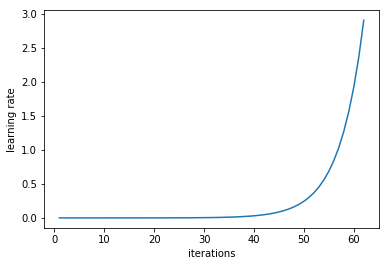

In [18]:
learn.sched.plot_lr()

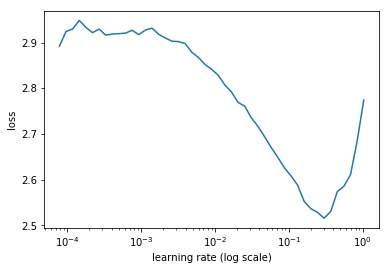

In [19]:
learn.sched.plot()

# Train last layer from precomputed activations for 1-2 epochs

In [20]:
learning_rate = 0.15
learning_rates = [learning_rate/9, learning_rate/3, learning_rate]

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.179242   1.432274   0.527922  
    1      1.754092   1.29931    0.575738                 
    2      1.370644   1.206033   0.576027                 
    3      1.389736   1.223373   0.587963                 
    4      1.266685   1.229508   0.598235                 
    5      1.124118   1.11035    0.600188                 
    6      0.982942   1.104475   0.602141                  

CPU times: user 6min 51s, sys: 15.9 s, total: 7min 7s
Wall time: 1min 11s


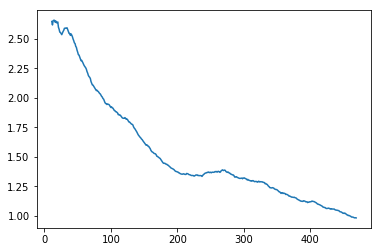

In [21]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.321684   0.876322   0.705367  
    1      1.007895   0.694128   0.769097                 
    2      0.641128   0.526354   0.826678                  
    3      0.67199    1.229819   0.634549                  
    4      0.530459   0.752692   0.77662                   
    5      0.338687   0.454465   0.857205                  
    6      0.224256   0.378968   0.879413                  

CPU times: user 7min 24s, sys: 26.1 s, total: 7min 51s
Wall time: 1min 48s


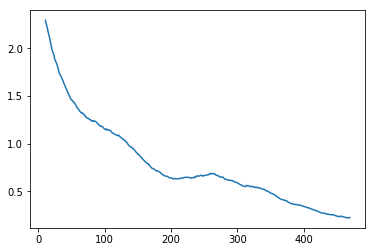

In [22]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [23]:
size = 150
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.142536   0.87675    0.706091  
    1      1.002095   0.772269   0.740741                 
    2      0.867514   0.678805   0.743924                  
    3      0.872025   0.700116   0.759042                  
    4      0.820516   0.686918   0.74197                   
    5      0.736534   0.602004   0.775897                  
    6      0.674942   0.573485   0.789569                  

CPU times: user 7min 53s, sys: 29.3 s, total: 8min 23s
Wall time: 1min 58s


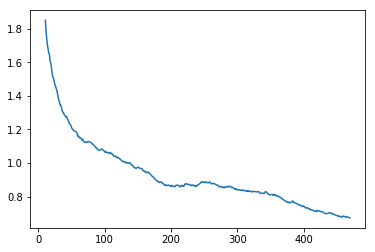

In [24]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.666536   0.410339   0.851562  
    1      0.528812   0.708906   0.778863                  
    2      0.339633   0.265196   0.912109                  
    3      0.394867   0.898834   0.766131                  
    4      0.292127   0.515066   0.850116                  
    5      0.182112   0.208079   0.925781                  
    6      0.11989    0.19077    0.931641                  

CPU times: user 9min 43s, sys: 1min 14s, total: 10min 58s
Wall time: 4min 28s


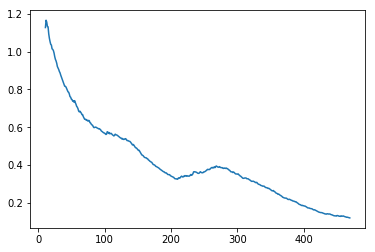

In [25]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [26]:
size = 400
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.606373   0.444094   0.84498   
    1      0.49173    0.33674    0.885272                  
    2      0.41031    0.333198   0.881366                  
    3      0.41197    0.356329   0.867694                  
    4      0.386459   0.297564   0.885272                  
    5      0.333246   0.280642   0.887225                  
    6      0.294895   0.273497   0.895038                  

CPU times: user 15min 16s, sys: 3min 28s, total: 18min 45s
Wall time: 8min 21s


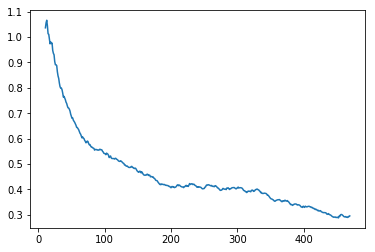

In [27]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.491924   0.262148   0.919198  
    1      0.379844   0.490162   0.855252                  
    2      0.227868   0.164953   0.941406                  
    3      0.268499   0.591827   0.835214                  
    4      0.221715   0.44014    0.859158                  
    5      0.140802   0.11411    0.958984                  
    6      0.093016   0.118821   0.962891                   

CPU times: user 25min 3s, sys: 6min 46s, total: 31min 49s
Wall time: 21min 23s


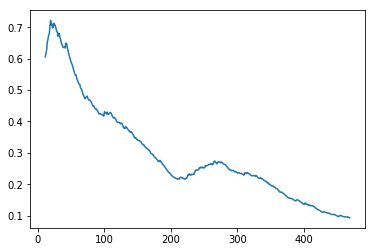

In [28]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

## Current latest standing doesn't include the following fit'

In [47]:
size = 500
bs=32
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.138942   0.1413     0.95      
    1      0.15708    0.180773   0.949614                    
    2      0.124215   0.164644   0.95625                     
    3      0.141305   0.216051   0.958333                    
    4      0.147171   0.233168   0.941667                    
    5      0.107742   0.158103   0.958333                     
    6      0.087099   0.1543     0.958333                     

CPU times: user 19min 42s, sys: 5min, total: 24min 42s
Wall time: 11min 52s


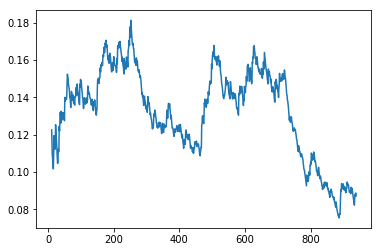

In [48]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

In [ ]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.511976   0.259546   0.914583  
    1      0.537407   0.489227   0.842593                    
    2      0.223648   0.155764   0.945833                    
 42%|████▏     | 56/134 [01:50<02:33,  1.97s/it, loss=0.364]

# Check accuracy

## Validation set

In [ ]:
log_preds, y = learn.TTA()

In [ ]:
log_preds.shape

In [ ]:
log_preds[:,0,:]

In [ ]:
y.shape

In [ ]:
y[:5]

In [ ]:
probs = np.mean(np.exp(log_preds), 0)

In [ ]:
probs.shape

In [ ]:
probs[0,:]

In [ ]:
accuracy(probs, y)

## Test set

In [29]:
learn.data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [30]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds), 0)
print(accuracy(test_probs, test_y))

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


In [31]:
print(test_probs.shape)
print(test_probs[:4])
print(test_probs[0, 0])

(794, 12)
[[0.06043 0.00001 0.00001 0.      0.93936 0.      0.00009 0.00001 0.      0.      0.      0.00009]
 [0.      0.      0.00002 0.      0.      0.00004 0.      0.      0.      0.      0.99994 0.     ]
 [0.      0.      0.00001 0.      0.      0.00017 0.      0.      0.      0.      0.99983 0.     ]
 [0.      0.      0.      0.      0.      0.00003 0.      0.99997 0.      0.      0.      0.     ]]
0.060425617


In [32]:
class_indexes = np.argmax(test_probs, axis=1)

In [33]:
learn.data.classes[class_indexes[0]]

'Common wheat'

# Submit to kaggle (optional)

In [34]:
test_classes = [learn.data.classes[i] for i in class_indexes]
print(len(test_classes))
print(test_classes[:5])


794
['Common wheat', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Maize', 'Small-flowered Cranesbill']


In [35]:
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(len(test_filenames))
print(test_filenames[:5])

794
['test/79e5ea8fa.png', 'test/3a909ead8.png', 'test/599691cd9.png', 'test/5ca2687a4.png', 'test/3dd52bd2a.png']


In [36]:
fileIds = np.array([f[5:] for f in test_filenames])
fileIds[:5]

array(['79e5ea8fa.png', '3a909ead8.png', '599691cd9.png', '5ca2687a4.png', '3dd52bd2a.png'], dtype='<U13')

In [37]:
submission = np.stack([fileIds,test_classes], axis=1)
submission[:5]

array([['79e5ea8fa.png', 'Common wheat'],
       ['3a909ead8.png', 'Small-flowered Cranesbill'],
       ['599691cd9.png', 'Small-flowered Cranesbill'],
       ['5ca2687a4.png', 'Maize'],
       ['3dd52bd2a.png', 'Small-flowered Cranesbill']], dtype='<U25')

In [38]:
!pwd

/home/paperspace/fastai/courses/dl1


In [39]:
now = datetime.datetime.now()
submission_file_name = f'plant-seed-submission-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%s,%s', header='file,species', comments='')

In [40]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/plant-seed-submission-2018-02-03 11:38:37.907028.csv

In [41]:
!date

Sat Feb  3 11:38:40 EST 2018
